In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split


In [2]:
output_dir = os.path.join(".", "output_front_ppo")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_f = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_f[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_f.shape)
combined_tensor_f = torch.from_numpy(combined_arr_f)

(10000, 1000, 10)


In [3]:
output_dir = os.path.join(".", "output_bw_sac")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_b = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_b[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_b.shape)
combined_tensor_b = torch.from_numpy(combined_arr_b)

(10000, 1000, 10)


In [4]:
output_dir = os.path.join(".", "output_right_ppo")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_r = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_r[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_r.shape)
combined_tensor_r = torch.from_numpy(combined_arr_r)

(10000, 1000, 10)


In [5]:
output_dir = os.path.join(".", "output_jelly")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr_j = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr_j[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr_j.shape)
combined_tensor_j = torch.from_numpy(combined_arr_j)

(10000, 1000, 10)


# VAE code -1

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var, h


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var, h = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

In [7]:
# Assuming combined_tensor is your data
# Convert the data to float32
datasetf = TensorDataset(combined_tensor_f.float())
datasetb = TensorDataset(combined_tensor_b.float())
datasetr = TensorDataset(combined_tensor_r.float())
datasetj = TensorDataset(combined_tensor_j.float())
# Define the data loader
batch_size = 512  # adjust as necessary
 
del combined_tensor_f
del combined_tensor_b
del combined_tensor_r
# del combined_tensor_j

In [8]:
# Split data into train, validation, and test
ftrain_size = int(0.7 * len(datasetf))  # 70% for training
fvalid_size = int(0.15 * len(datasetf))  # 15% for validation
ftest_size = len(datasetf) - ftrain_size - fvalid_size  # 15% for testing

ftrain_dataset, fvalid_dataset, ftest_dataset = random_split(datasetf, [ftrain_size, fvalid_size, ftest_size])

ftrain_loader = DataLoader(ftrain_dataset, batch_size=batch_size, shuffle=True)
fvalid_loader = DataLoader(fvalid_dataset, batch_size=batch_size, shuffle=True)
ftest_loader = DataLoader(ftest_dataset, batch_size=batch_size, shuffle=True)


In [9]:
# Split data into train, validation, and test
btrain_size = int(0.7 * len(datasetb))  # 70% for training
bvalid_size = int(0.15 * len(datasetb))  # 15% for validation
btest_size = len(datasetb) - btrain_size - bvalid_size  # 15% for testing

btrain_dataset, bvalid_dataset, btest_dataset = random_split(datasetb, [btrain_size, bvalid_size, btest_size])

btrain_loader = DataLoader(btrain_dataset, batch_size=batch_size, shuffle=True)
bvalid_loader = DataLoader(bvalid_dataset, batch_size=batch_size, shuffle=True)
btest_loader = DataLoader(btest_dataset, batch_size=batch_size, shuffle=True)


In [10]:
# Split data into train, validation, and test
rtrain_size = int(0.7 * len(datasetr))  # 70% for training
rvalid_size = int(0.15 * len(datasetr))  # 15% for validation
rtest_size = len(datasetr) - rtrain_size - rvalid_size  # 15% for testing

rtrain_dataset, rvalid_dataset, rtest_dataset = random_split(datasetr, [rtrain_size, rvalid_size, rtest_size])

rtrain_loader = DataLoader(rtrain_dataset, batch_size=batch_size, shuffle=True)
rvalid_loader = DataLoader(rvalid_dataset, batch_size=batch_size, shuffle=True)
rtest_loader = DataLoader(rtest_dataset, batch_size=batch_size, shuffle=True)


In [11]:
# Split data into train, validation, and test
jtrain_size = int(0.7 * len(datasetj))  # 70% for training
jvalid_size = int(0.15 * len(datasetj))  # 15% for validation
jtest_size = len(datasetj) - jtrain_size - jvalid_size  # 15% for testing

jtrain_dataset, jvalid_dataset, jtest_dataset = random_split(datasetj, [jtrain_size, jvalid_size, jtest_size])

jtrain_loader = DataLoader(jtrain_dataset, batch_size=batch_size, shuffle=True)
jvalid_loader = DataLoader(jvalid_dataset, batch_size=batch_size, shuffle=True)
jtest_loader = DataLoader(jtest_dataset, batch_size=batch_size, shuffle=True)


In [12]:
# Hyperparameters
# input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
# hidden_dim1 = 128  # modify as needed
# hidden_dim2 = 64  # modify as needed
# hidden_dim3 = 24  # modify as needed
# latent_dim = 2  # modify as needed
# lr = 5e-5  # learning rate
# n_epochs = 200  # modify as needed
# beta = 0.2
input_shape = combined_tensor_j.shape[1] * combined_tensor_j.shape[2]  # modify this to match your data
hidden_dim1 = 24  # modify as needed
hidden_dim2 = 12  # modify as needed
hidden_dim3 = 12  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 200  # modify as needed
beta = 0.2
    

# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div


====> Epoch: 1 Average loss: 0.013681015763963971, Recon Loss: 0.0020025973149708338, KL Div: 0.05839209120614188
====> Epoch: 2 Average loss: 0.012337133748190744, Recon Loss: 0.0020027458667755127, KL Div: 0.05167193767002651
====> Epoch: 3 Average loss: 0.011050561155591693, Recon Loss: 0.0020016995327813286, KL Div: 0.04524430683680943
====> Epoch: 4 Average loss: 0.009776033844266618, Recon Loss: 0.002000562310218811, KL Div: 0.03887735639299665
====> Epoch: 5 Average loss: 0.009363633292061942, Recon Loss: 0.001999508466039385, KL Div: 0.03682062353406634
====> Epoch: 6 Average loss: 0.008955981867653983, Recon Loss: 0.001997053827558245, KL Div: 0.03479463904244559
====> Epoch: 7 Average loss: 0.00854538140978132, Recon Loss: 0.001995659947395325, KL Div: 0.03274860722678048
====> Epoch: 8 Average loss: 0.008111039638519286, Recon Loss: 0.0019935484783990044, KL Div: 0.030587456021990096
====> Epoch: 9 Average loss: 0.0077098545006343295, Recon Loss: 0.0019912323951721193, KL Di

====> Epoch: 72 Average loss: 0.0022378287826265606, Recon Loss: 0.0014743381312915258, KL Div: 0.003817453248160226
====> Epoch: 73 Average loss: 0.002157372679029192, Recon Loss: 0.0014511854989188058, KL Div: 0.0035309359175818306
====> Epoch: 74 Average loss: 0.0020839241828237262, Recon Loss: 0.0014327055897031512, KL Div: 0.003256093042237418
====> Epoch: 75 Average loss: 0.002007886350154877, Recon Loss: 0.0014092018263680594, KL Div: 0.0029934225508144925
====> Epoch: 76 Average loss: 0.0019342122673988342, Recon Loss: 0.0013855513589722769, KL Div: 0.0027433044484683447
====> Epoch: 77 Average loss: 0.00186564815895898, Recon Loss: 0.0013644706777163915, KL Div: 0.002505887372153146
====> Epoch: 78 Average loss: 0.0017961726784706115, Recon Loss: 0.0013398935198783875, KL Div: 0.0022813957418714253
====> Epoch: 79 Average loss: 0.0017295708060264588, Recon Loss: 0.001315611515726362, KL Div: 0.0020697964089257375
====> Epoch: 80 Average loss: 0.0016661268728119987, Recon Loss:

====> Epoch: 141 Average loss: 0.000308178329042026, Recon Loss: 0.00030667835686888016, KL Div: 7.499835320881435e-06
====> Epoch: 142 Average loss: 0.00030218074790069036, Recon Loss: 0.00030071864809308734, KL Div: 7.310488394328526e-06
====> Epoch: 143 Average loss: 0.0002980756078447614, Recon Loss: 0.00029664246737957, KL Div: 7.165687424795968e-06
====> Epoch: 144 Average loss: 0.00029506439183439527, Recon Loss: 0.00029365806707314085, KL Div: 7.031632321221488e-06
====> Epoch: 145 Average loss: 0.0002897283881902695, Recon Loss: 0.0002883536560194833, KL Div: 6.873658725193568e-06
====> Epoch: 146 Average loss: 0.00028560943050043926, Recon Loss: 0.000284264617732593, KL Div: 6.724042551858084e-06
====> Epoch: 147 Average loss: 0.00028251022739069804, Recon Loss: 0.0002811918726989201, KL Div: 6.591750042779105e-06
====> Epoch: 148 Average loss: 0.00027843850425311495, Recon Loss: 0.00027714619891984124, KL Div: 6.461543696267264e-06
====> Epoch: 149 Average loss: 0.0002745961

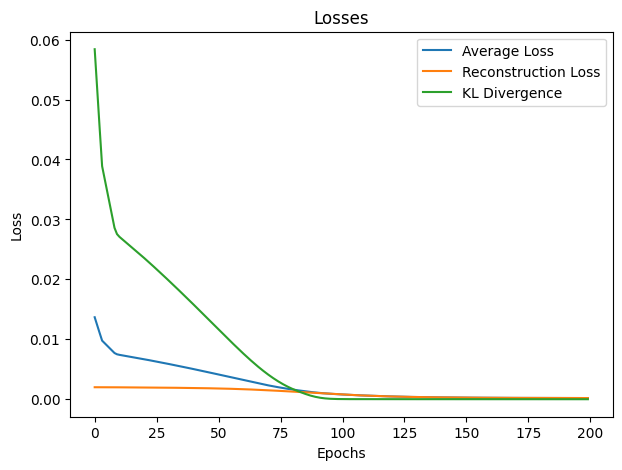

In [13]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
favg_losses = []
favg_recon_losses = []
favg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    favg_loss, favg_recon_loss, favg_kl_div = train(epoch, model, optimizer, loss_fn, ftrain_loader)
    favg_losses.append(favg_loss)
    favg_recon_losses.append(favg_recon_loss)
    favg_kl_divs.append(favg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(favg_losses, label='Average Loss')
plt.plot(favg_recon_losses, label='Reconstruction Loss')
plt.plot(favg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
bavg_losses = []
bavg_recon_losses = []
bavg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    bavg_loss, bavg_recon_loss, bavg_kl_div = train(epoch, model, optimizer, loss_fn, btrain_loader)
    bavg_losses.append(bavg_loss)
    bavg_recon_losses.append(bavg_recon_loss)
    bavg_kl_divs.append(bavg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(bavg_losses, label='Average Loss')
plt.plot(bavg_recon_losses, label='Reconstruction Loss')
plt.plot(bavg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


====> Epoch: 1 Average loss: 0.010777041401181903, Recon Loss: 0.005909012930733817, KL Div: 0.024340142045702253
====> Epoch: 2 Average loss: 0.007205849375043596, Recon Loss: 0.0055852735383169995, KL Div: 0.00810287880897522
====> Epoch: 3 Average loss: 0.00659471777507237, Recon Loss: 0.005324483326503209, KL Div: 0.006351171834128244
====> Epoch: 4 Average loss: 0.006283089331218175, Recon Loss: 0.005133389098303659, KL Div: 0.005748501096452986
====> Epoch: 5 Average loss: 0.006042861461639405, Recon Loss: 0.0049881223951067245, KL Div: 0.005273695128304618
====> Epoch: 6 Average loss: 0.005798498153686524, Recon Loss: 0.004871499708720616, KL Div: 0.004634991935321263
====> Epoch: 7 Average loss: 0.005480643340519497, Recon Loss: 0.0047789306640625, KL Div: 0.003508563484464373
====> Epoch: 8 Average loss: 0.005103321177618844, Recon Loss: 0.0046963391985212054, KL Div: 0.0020349098443984987
====> Epoch: 9 Average loss: 0.0048103428568158834, Recon Loss: 0.004624521153313773, KL

====> Epoch: 72 Average loss: 0.0034830473150525773, Recon Loss: 0.003480088574545724, KL Div: 1.4793791941234044e-05
====> Epoch: 73 Average loss: 0.003470152088574001, Recon Loss: 0.0034672552176884244, KL Div: 1.4484448092324393e-05
====> Epoch: 74 Average loss: 0.0034609474624906268, Recon Loss: 0.0034581338337489535, KL Div: 1.4068250145230975e-05
====> Epoch: 75 Average loss: 0.0034490971054349628, Recon Loss: 0.0034463316202163695, KL Div: 1.3827379260744368e-05
====> Epoch: 76 Average loss: 0.003438378589493888, Recon Loss: 0.0034356830971581597, KL Div: 1.3477440391268049e-05
====> Epoch: 77 Average loss: 0.003434782385826111, Recon Loss: 0.0034321532930646622, KL Div: 1.3145531926836286e-05
====> Epoch: 78 Average loss: 0.0034190643514905657, Recon Loss: 0.0034164984907422745, KL Div: 1.2829282454081944e-05
====> Epoch: 79 Average loss: 0.003414249539375305, Recon Loss: 0.0034117329461233956, KL Div: 1.2582949229649135e-05
====> Epoch: 80 Average loss: 0.003408507755824498, R

====> Epoch: 142 Average loss: 0.0030167978831699914, Recon Loss: 0.003016047988619123, KL Div: 3.749417407172067e-06
====> Epoch: 143 Average loss: 0.003019754137311663, Recon Loss: 0.0030189941780907766, KL Div: 3.799779074532645e-06
====> Epoch: 144 Average loss: 0.003020594733101981, Recon Loss: 0.0030198542731148855, KL Div: 3.702291420527867e-06
====> Epoch: 145 Average loss: 0.0030132045916148593, Recon Loss: 0.0030124647787639074, KL Div: 3.699051482336862e-06
====> Epoch: 146 Average loss: 0.003004043698310852, Recon Loss: 0.0030033140523093088, KL Div: 3.6482087203434536e-06
====> Epoch: 147 Average loss: 0.0029970909016472955, Recon Loss: 0.0029963756118501937, KL Div: 3.5764873027801515e-06
====> Epoch: 148 Average loss: 0.0030032517399106707, Recon Loss: 0.0030025499037333895, KL Div: 3.5091468266078404e-06
====> Epoch: 149 Average loss: 0.0030009967940194267, Recon Loss: 0.0030003022125789096, KL Div: 3.4730264118739536e-06
====> Epoch: 150 Average loss: 0.002993703859192

In [ ]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
ravg_losses = []
ravg_recon_losses = []
ravg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    ravg_loss, ravg_recon_loss, ravg_kl_div = train(epoch, model, optimizer, loss_fn, rtrain_loader)
    ravg_losses.append(ravg_loss)
    ravg_recon_losses.append(ravg_recon_loss)
    ravg_kl_divs.append(ravg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(ravg_losses, label='Average Loss')
plt.plot(ravg_recon_losses, label='Reconstruction Loss')
plt.plot(ravg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
javg_losses = []
javg_recon_losses = []
javg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    javg_loss, javg_recon_loss, javg_kl_div = train(epoch, model, optimizer, loss_fn, jtrain_loader)
    javg_losses.append(javg_loss)
    javg_recon_losses.append(javg_recon_loss)
    javg_kl_divs.append(javg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(javg_losses, label='Average Loss')
plt.plot(javg_recon_losses, label='Reconstruction Loss')
plt.plot(javg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# see the output

# latent space plot

In [ ]:
# Get encoded representations (h values) for all data points
encoded_representations_forward = []
encoded_representations_backward = []
encoded_representations_right = []
encoded_representations_jelly = []
model.eval()
with torch.no_grad():
    for batch in ftest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_forward.append(h)

encoded_representations_forward = torch.cat(encoded_representations_forward, dim=0).numpy()

with torch.no_grad():
    for batch in btest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_backward.append(h)
        
encoded_representations_backward = torch.cat(encoded_representations_backward, dim=0).numpy()

with torch.no_grad():
    for batch in rtest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_right.append(h)
        
encoded_representations_right = torch.cat(encoded_representations_right, dim=0).numpy()

with torch.no_grad():
    for batch in jtest_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations_jelly.append(h)

encoded_representations_jelly = torch.cat(encoded_representations_jelly, dim=0).numpy()

# # Assuming the encoded representations are 2D, plot the data in 2D space
# plt.figure(figsize=(8, 6))
# plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], alpha=0.5, s=3)
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.title('2D Visualization of Encoded Representations (h values)')
# plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations_forward[:, 0], encoded_representations_forward[:, 1], alpha=0.5, s=3, label='Forward')
plt.scatter(encoded_representations_backward[:, 0], encoded_representations_backward[:, 1], alpha=0.5, s=3, label='Backward')
plt.scatter(encoded_representations_right[:, 0], encoded_representations_right[:, 1], alpha=0.5, s=3, label='Right')
plt.scatter(encoded_representations_jelly[:, 0], encoded_representations_jelly[:, 1], alpha=0.5, s=3, label='Jelly')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.legend()
plt.show()
